# Pump it Up: Data Mining the Water Table
### HOSTED BY DRIVENDATA

#### Competition is mainly targeted a classification problem where predictions are needed to be done for the functionality of the water pumps (operating condition of the waterpoint) used in South African country, Tanzaniya. 
#### More info can be found here on [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

#### For clarification, categorization should be done according to the following distribution labels.
* **functional** - the waterpoint is operational and there are no repairs needed
* **functional needs repair** - the waterpoint is operational, but needs repairs
* **non functional** - the waterpoint is not operational




## Import python libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import stats
import datetime

## Train values and labels are imported as follows from the given csv files.

In [2]:
df = pd.read_csv("train_values.csv")

label = pd.read_csv("train_labels.csv")

## Check train values

In [3]:
df.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Check train labels

In [4]:
label.head(5)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## Label encoding for train labels
* **functional** - 0
* **functional need repair** - 1
* **non functional** - 2

In [5]:
label_encoder = preprocessing.LabelEncoder()
label['status_group'] = label_encoder.fit_transform(label['status_group'])

## Some of the features were removed due to following observations
* **Most of the categorical features in the dataset show similarity**
* **Lack of explicit correspondence to the given problem**
* **Null randomness**

reasoning for removal of some features are given below explicitly

### Reasoning for removal of features

In [6]:
source_cols = ['source_class', 'source_type']
waterpoint_type_cols = ['waterpoint_type_group', 'water_quality']
extraction_type_cols = ['extraction_type_group', 'extraction_type']
quality_cols = ['quality_group','water_quality']
quantity_cols = ['quantity_group','quantity']

similar_cols = [source_cols, waterpoint_type_cols, extraction_type_cols, quality_cols, quantity_cols]
 
for col_array in similar_cols:
    print("************************SIMILARITY OF THE GIVEN COLUMNS**********************************")
    for col in col_array:
        print(df[col].unique())
    print('*****************************************************************************************')

************************SIMILARITY OF THE GIVEN COLUMNS**********************************
['groundwater' 'surface' 'unknown']
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
*****************************************************************************************
************************SIMILARITY OF THE GIVEN COLUMNS**********************************
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
*****************************************************************************************
************************SIMILARITY OF THE GIVEN COLUMNS**********************************
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 '

### Geographical location of waterpoints can be identified by ward and lga.
### therefore following features can be avoided due to the similar information

* **subvillage**
* **region**
* **region_code**
* **district_code**

In [7]:
drop_list = ['funder',
             'installer',
             'recorded_by',
             'wpt_name',
             'scheme_name',
             'waterpoint_type_group',
             'extraction_type_group',
             'public_meeting',
             'subvillage',
             'region',
             'region_code',
             'district_code',
             'recorded_by',
             'quality_group',
             'quantity_group',
             'id',
             'source',
             'source_class'
            ]

def dropcolums(dataframe):
    dataframe.drop(drop_list,axis=1,inplace=True)
    
dropcolums(df)

## Check null data for columns 

In [8]:
df.isnull().sum()

amount_tsh                  0
date_recorded               0
gps_height                  0
longitude                   0
latitude                    0
num_private                 0
basin                       0
lga                         0
ward                        0
population                  0
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

## Fill null columns

In [9]:
def fillnullcolumns(dataframe):
    values = {'permit': 1,'scheme_management':'Other'}
    dataframe.fillna(value=values,inplace = True)

fillnullcolumns(df)

## Convertion of given features 

In [10]:
def featureconversion(dataframe):
    dataframe['date_recorded'] = pd.to_datetime(dataframe['date_recorded'], errors='coerce')
    now = pd.to_datetime('now')
    dataframe['time_for_record'] = ((now - dataframe['date_recorded']).dt.total_seconds() / (60*60*24*365.25)).round(0)
    dataframe['time_to_construction_year'] = datetime.datetime.now().year - dataframe['construction_year']
    
    # for some data, construction year given as 0, therefore year of the recorded time given for those data
    dataframe['time_to_construction_year'] = np.where(dataframe['time_to_construction_year'] == 2019, dataframe['time_for_record'], dataframe['time_to_construction_year'])

In [11]:
featureconversion(df)

## Deletion of converted columns 

In [12]:
columns_to_delete = ["date_recorded","construction_year"]

def columndeletion(dataframe):
    dataframe.drop(labels=columns_to_delete, axis="columns", inplace=True)

columndeletion(df)

## Data Mapping of the given features 

In [13]:
dataMapper = {'VWC':'VWC',
              'WUG':'WUG',
              'Water Board':'Water Board',
              'WUA':'WUA',
              'Water authority':'Water authority',
              'Private operator':'Other',
              'Company':'Other',
              'Trust':'Other',
              'Parastatal':'Other',
              'SWC':'Other',
              'None':'Other',
              'Other':'Other'
             }
def datamapping(dataframe):
    dataframe['scheme_management']=dataframe['scheme_management'].map(dataMapper)

In [14]:
value_replacement_1 = {'commercial':'other', 'parastatal':'other', 'unknown':'other'}

def valreplace_1(dataframe):
    dataframe['management_group'].replace(value_replacement_1, inplace=True)

valreplace_1(df)

In [15]:
value_replacement_2 = {'dam':'other', 'rainwater harvesting':'other'}

def valreplace_2(dataframe):
    dataframe['source_type'].replace(value_replacement_2, inplace=True)

valreplace_2(df)

In [16]:
value_replacement_3 = {'salty':'other',
                     'milky':'other', 
                     'unknown':'other', 
                     'fluoride':'other', 
                     'coloured':'other',
                     'salty abandoned':'other', 
                     'fluoride abandoned':'other'
                    }

def valreplace_3(dataframe):
    dataframe['water_quality'].replace(value_replacement_3,inplace=True)

valreplace_3(df)

## Encoding of non-numerical categorical features

In [17]:
def encoding(dataframe):
    dataframe_objects = dataframe.select_dtypes(include=['object'])
    label_encoder = preprocessing.LabelEncoder()
    for col in dataframe_objects.columns:
        dataframe[col] = label_encoder.fit_transform(dataframe[col])

encoding(df)

## Conversion of data into a numpy array 

In [18]:
X = df.values
Y = label.values
Y=Y[:,1] # to remove id column

## Model selection and training 

In [19]:
randomForestModel = RandomForestClassifier(n_estimators=80,max_depth=20)

In [20]:
def getScore(model,X_train,Y_train,X_test,Y_test):
    model.fit(X_train,Y_train)
    return model.score(X_test,Y_test)

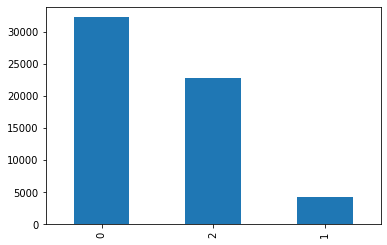

In [21]:
label['status_group'].value_counts().plot(kind='bar')

### Here we can find labels for train dataset is not equally distributed. Therefore StratifiedKFold has been used for cross validation since it divides train and test data for each split with the balancing of each label class.

In [22]:
kfold = StratifiedKFold(n_splits=10)

In [23]:
RF_score=[]

for train_index,test_index in kfold.split(X,Y):
    X_train,X_test,Y_train,Y_test = X[train_index],X[test_index],Y[train_index],Y[test_index]
    RF_score.append(getScore(randomForestModel,X_train,Y_train,X_test,Y_test))

## Check model prediction score for train data split 

In [24]:
from sklearn.metrics import accuracy_score
predictions = randomForestModel.predict(X_train)
accuracy_score(Y_train,predictions)

0.9452508323669149

## RandomForest model predictions for test data split

In [25]:
RF_score # prediction score for each k-fold

[0.8166975256690793,
 0.8156875946810301,
 0.8103012960781013,
 0.8103012960781013,
 0.8235690235690236,
 0.8095959595959596,
 0.8153198653198653,
 0.8045125441993601,
 0.8026603805354436,
 0.8172785449646346]

In [26]:
avg_rf_classification_score = sum(RF_score)/len(RF_score) #averaged k-fold prediction score
print(avg_rf_classification_score)

0.81259240306906


## Load the test values from the Test_set_values.csv file for predictions 

In [27]:
test_for_pred = pd.read_csv("Test_set_values.csv")

In [28]:
load_ids = test_for_pred['id'].values

## Data preprocessing for test values

In [29]:
def preprocesing(dataframe):
    
    dropcolums(dataframe)
    
    fillnullcolumns(dataframe)
    
    featureconversion(dataframe)
    
    columndeletion(dataframe)
    
    datamapping(dataframe)
    
    valreplace_1(dataframe)
    
    valreplace_2(dataframe)
    
    valreplace_3(dataframe)
    
    encoding(dataframe)
    
    X = dataframe.values
    
    return randomForestModel.predict(X)

## Prediction for test values

In [30]:
final_pred = preprocesing(test_for_pred)

## Arrange predicted test labels for submission 

In [31]:
result = pd.Series(final_pred).replace(to_replace = [0, 1, 2], value = ['functional', 'functional needs repair', 'non functional']) 

In [32]:
evaluation = pd.DataFrame({'id':load_ids[:],"status_group": result.values[:]})

In [33]:
evaluation.head(5)

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [34]:
evaluation.to_csv("submission.csv",index=False)

## DATA DRIVEN COMPETITION RESULTS FOR PUBLIC TEST DATASET

#### Early results ended up with a lesser accuracy due to a mistake happened in label encoding in test labels

## rank in competition (so far)

![rank in competition (so far)](drivendata_1.png)

## results (so far)

![results (so far)](drivendata_2.png)